In [57]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV

class WeatherModel():
    def __init__(self, filename, start_year=2003, end_year=2024):
        self.data = pd.read_csv(filename)
        self.data = self.data.drop(columns=['GUST', 'SNDP', 'STP'])
        self.data = self.data.replace(999.9, pd.NA)
        self.data = self.data.replace(9999.9, pd.NA)
        self.data['PRCP'] = self.data['PRCP'].replace(99.99, pd.NA)
        self.data['DATE'] = pd.to_datetime(self.data['DATE'])
        self.data = self.data[(self.data['DATE'].dt.year >= start_year) & (self.data['DATE'].dt.year <= end_year)]
        self.data = self.data[~((self.data['DATE'].dt.month == 2) & (self.data['DATE'].dt.day == 29))]
        self.data = self.data.ffill()

        self.seasonal = None
        self.residuals = None

        self.year_data = self.get_year_data()
        self.arma_models = []

    def get_year_data(self):
        data = self.data[["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "SLP", "DEWP", "WDSP"]]
        data = data.to_numpy()

        drop_rows = data.shape[0] % 365
        data = data[:-drop_rows]

        data = data.reshape(-1, 365, data.shape[1])

        return data

    def get_seasonal_trend(self):
        
        seasonal = np.mean(self.year_data, axis=0)
        self.seasonal = seasonal

        return seasonal
    
    def get_residuals(self):
        
        if self.seasonal is None:
            self.get_seasonal_trend()

        residuals = self.year_data - self.seasonal
        residuals = residuals.reshape(-1, residuals.shape[2])
        self.residuals = residuals

        return residuals
    
    def fit_arma(self, order, train_stop = None):

        if train_stop is None:

            if self.residuals is None:
                self.get_residuals()

            arma_models = []

            pbar = tqdm(total=self.residuals.shape[1])

            for i in range(self.residuals.shape[1]):
                pbar.set_description(f"Fitting {i+1}/{self.residuals.shape[1]} ARMA models")
                pbar.update(1)
                model = ARIMA(self.residuals[:, i], order=order)
                model_fit = model.fit()
                arma_models.append(model_fit)
                
            self.arma_models = arma_models

            return None
        else:

            if self.residuals is None:
                self.get_residuals()

            arma_models = []

            pbar = tqdm(total=self.residuals[:,train_stop].shape[1])

            for i in range(self.residuals.shape[:,train_stop][1]):
                pbar.set_description(f"Fitting {i+1}/{self.residuals.shape[1]} ARMA models")
                pbar.update(1)
                model = ARIMA(self.residuals[:, i], order=order)
                model_fit = model[:,train_stop].fit()
                arma_models.append(model_fit)
                
            self.arma_models = arma_models

            return None

    def fit(self, order):
        self.fit_arma(order)
        return None
    
    # def fit(self, p,q, train_stop = None):
    #     self.fit_arma(order = (p,0,q), train_stop)
        # return None

    # def Grid(self):
    #     dict_for_GS = dict()
    #     dict_for_GS[p0] = [0,1,2,3,4,5,6,7]
    #     dict_for_GS[q0] = [0,1,2,3,4,5,6,7]
    #     GS = GridSearchCV(wm.fit, dict_for_GS, n_jobs = -1)
    #     GS.f=best_score
    #     wm.fit(1,0,1)
    #     models = wm.arma_models
    
    def predict(self, start=0, future=0):
        if len(self.arma_models) == 0:
            raise ValueError("Model not fitted yet")

        arma_predictions = np.array([model.predict(start=start, end=len(self.residuals) - start + future) for model in self.arma_models])

        season_start = start % 365
                
        num_stacks = arma_predictions.shape[1] // self.seasonal.shape[0]
        num_extras = arma_predictions.shape[1] % self.seasonal.shape[0]


        seasonal_predictions = np.vstack([self.seasonal for _ in range(num_stacks)])
        print("Seasonal Predictions", seasonal_predictions.shape)
        print("Residual shape", arma_predictions.shape)
        print("Num stacks", num_stacks)
        print("Num extras", num_extras)

        if num_extras > 0:
            seasonal_predictions = np.vstack((seasonal_predictions, self.seasonal[:num_extras].reshape(num_extras, -1)))



        return seasonal_predictions.T + arma_predictions
    



In [58]:
wm = WeatherModel('cotobato.csv')

#Defining score for model
def score(model):
    return ([model[i].aic for i in range(len(model))])

# dict_for_GS = dict()
# dict_for_GS["p0"] = [0,1,2,3,4,5,6,7]
# dict_for_GS["q0"] = [0,1,2,3,4,5,6,7]
# GS = GridSearchCV(wm, dict_for_GS, n_jobs = -1, scoring = score)
# GS.fit(wm.data)
# #GS.f = best_score
# models = wm.arma_models

#Making values to look over
wm = WeatherModel('cotobato.csv')


wm.fit(order=(1, 0, 1))

/tmp/ipykernel_20514/851080800.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.data = self.data.ffill()
/tmp/ipykernel_20514/851080800.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.data = self.data.ffill()
Fitting 8/8 ARMA models: 100%|██████████| 8/8 [00:09<00:00,  1.25s/it]


In [59]:
predictions = wm.predict(start=0, future=365*10)

Seasonal Predictions (10950, 8)
Residual shape (8, 10951)
Num stacks 30
Num extras 1


(8, 10951)
(8, 7300)


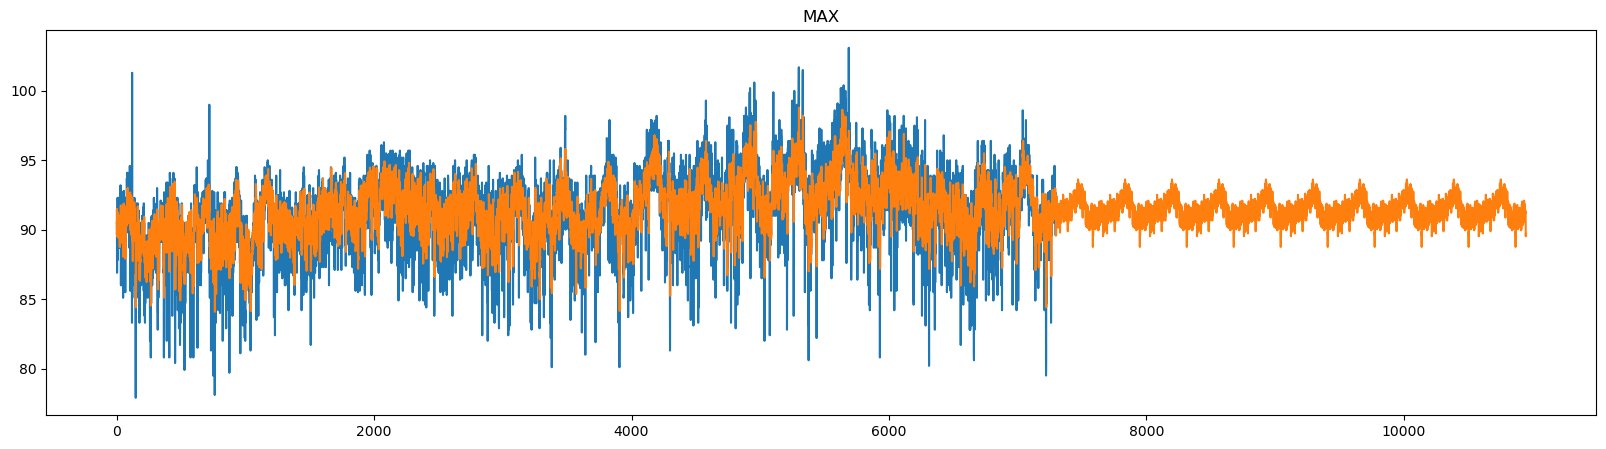

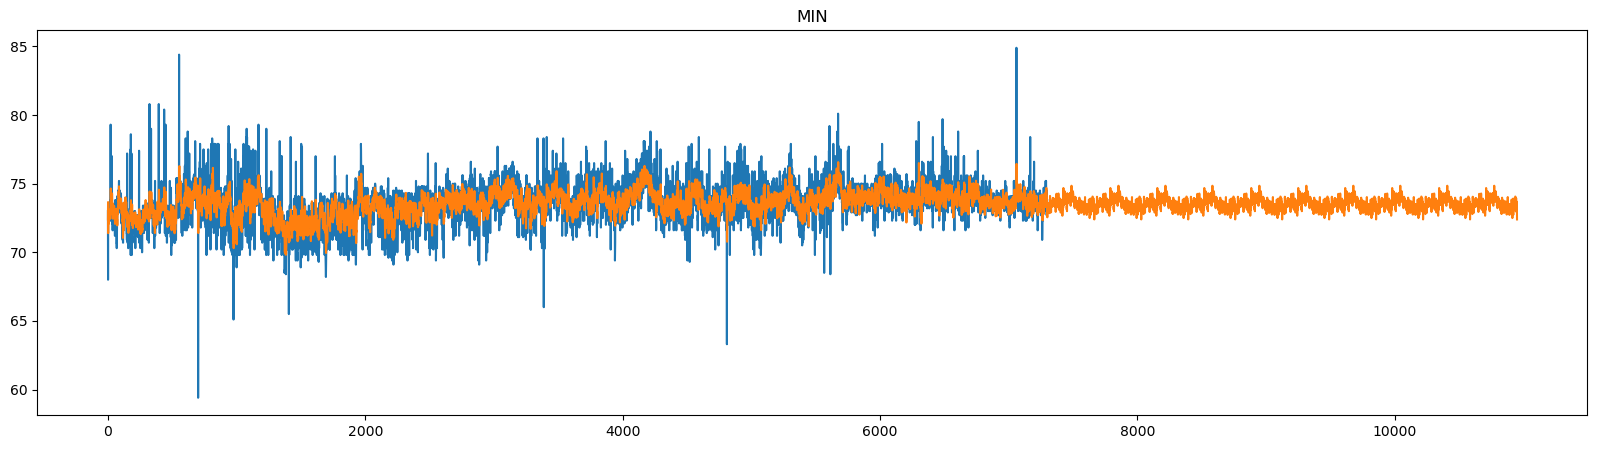

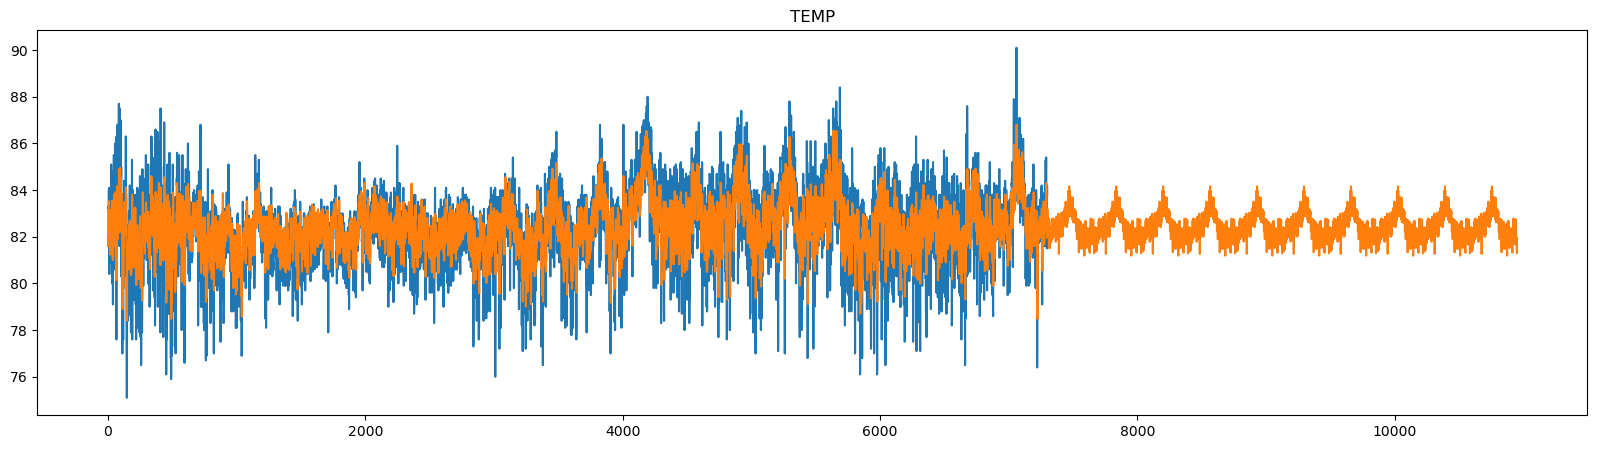

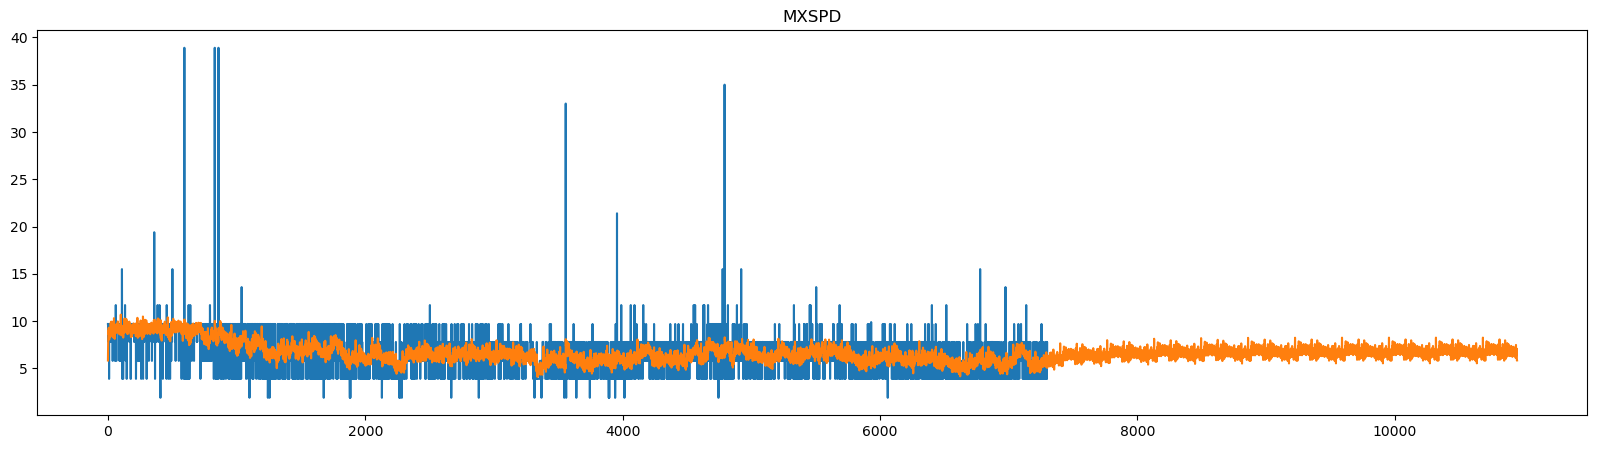

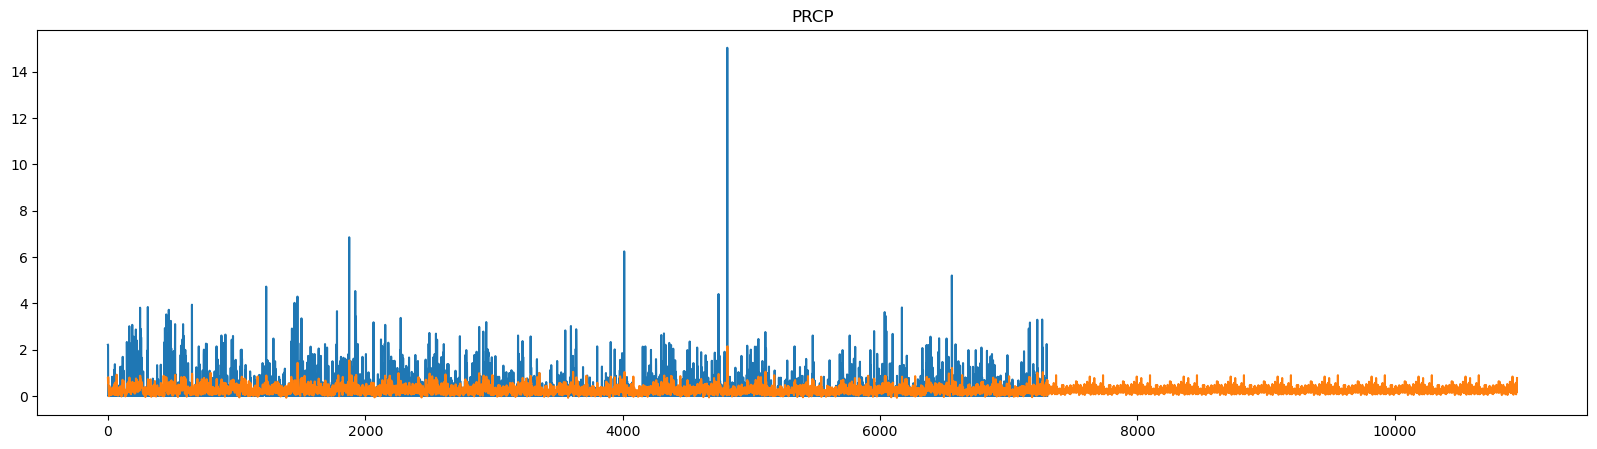

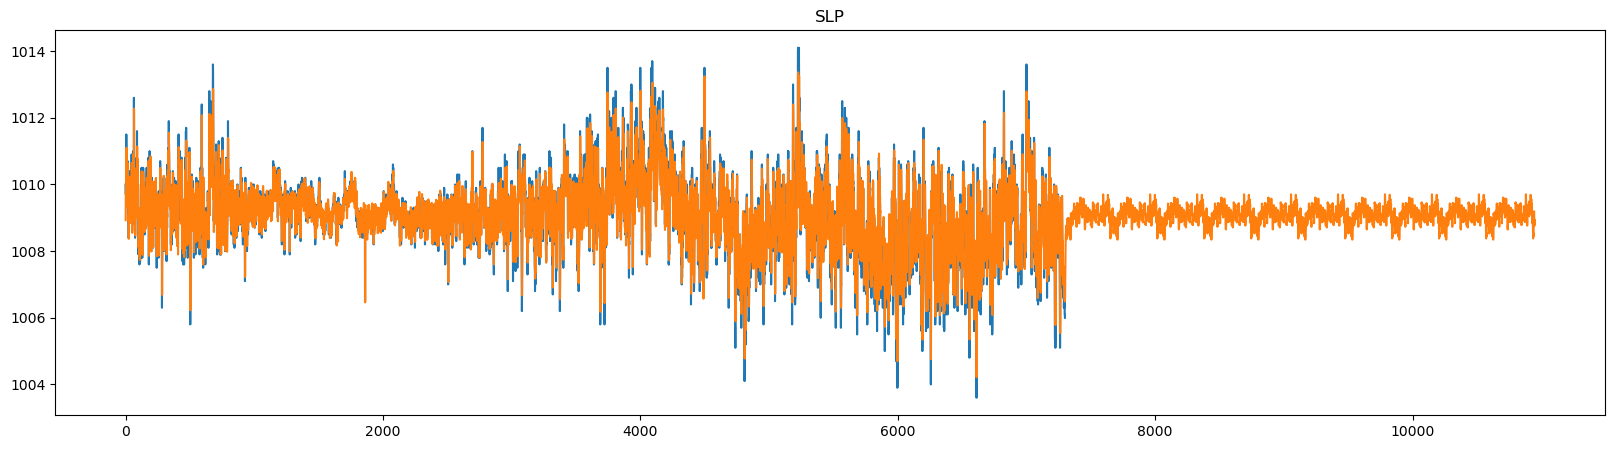

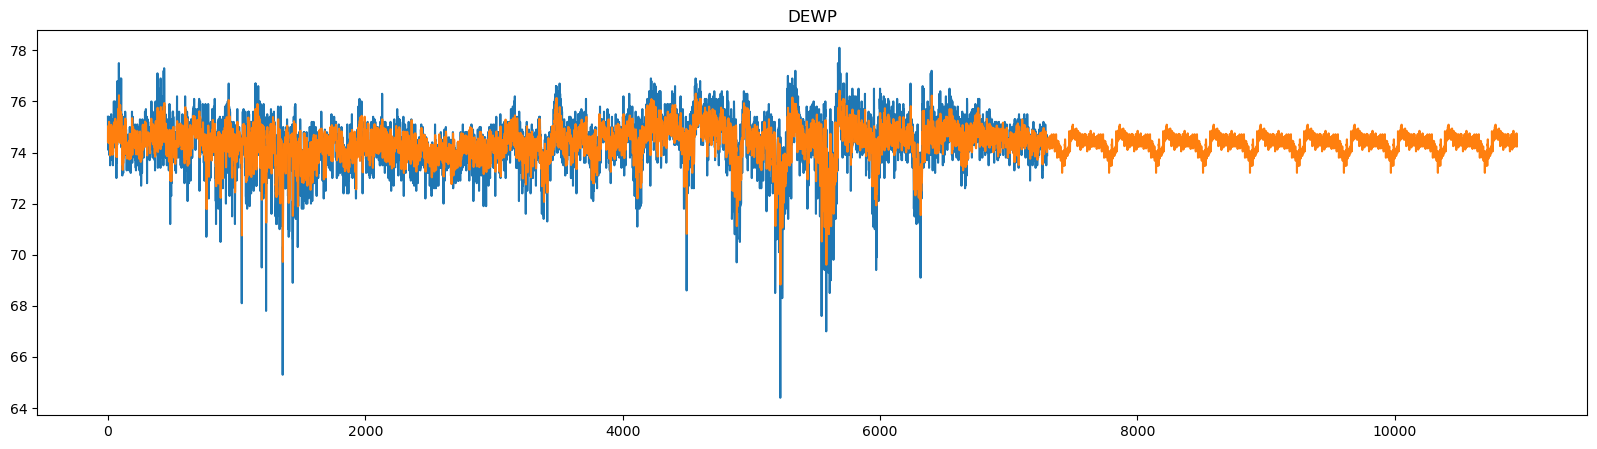

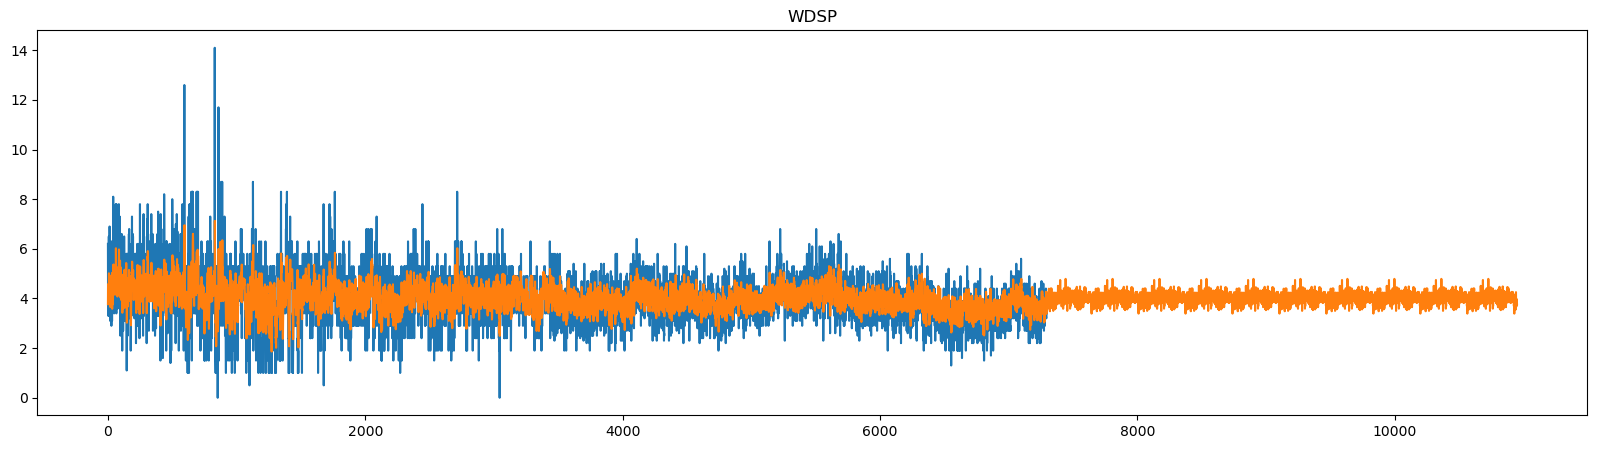

In [60]:
print(predictions.shape)

unrolled_data = wm.year_data.reshape(-1, wm.year_data.shape[2]).T
print(unrolled_data.shape)
feature_names = ["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "SLP", "DEWP", "WDSP"]
for i in range(len(predictions)):
    plt.figure(figsize=(20, 5))
    plt.title(feature_names[i])
    plt.plot(unrolled_data[i])
    plt.plot(predictions[i])
    plt.show()


(240,)
green (240,)
#date
2003-01-31    0.767067
2003-02-28    0.751433
2003-03-31    0.744467
2003-04-30    0.756300
2003-05-31    0.778533
Freq: ME, Name: residuals, dtype: float64 #date
2022-08-31    0.801700
2022-09-30    0.791767
2022-10-31    0.798200
2022-11-30    0.806533
2022-12-31    0.806400
Freq: ME, Name: residuals, dtype: float64
                  MAX        MIN       TEMP     MXSPD      PRCP          SLP  \
DATE                                                                           
2003-01-31  90.020000  73.016667  82.410000  9.380000  0.155000  1009.880000   
2003-02-28  89.555000  72.860000  82.090000  9.125000  0.108500  1009.755000   
2003-03-31  90.478261  72.165217  82.491304  9.278261  0.257826  1010.026087   
2003-04-30  91.893103  73.886207  84.351724  9.365517  0.067586  1009.617241   
2003-05-31  90.100000  72.361290  81.458065  9.264516  0.319677  1008.748387   

                 DEWP      WDSP  
DATE                             
2003-01-31  74.683333  4.

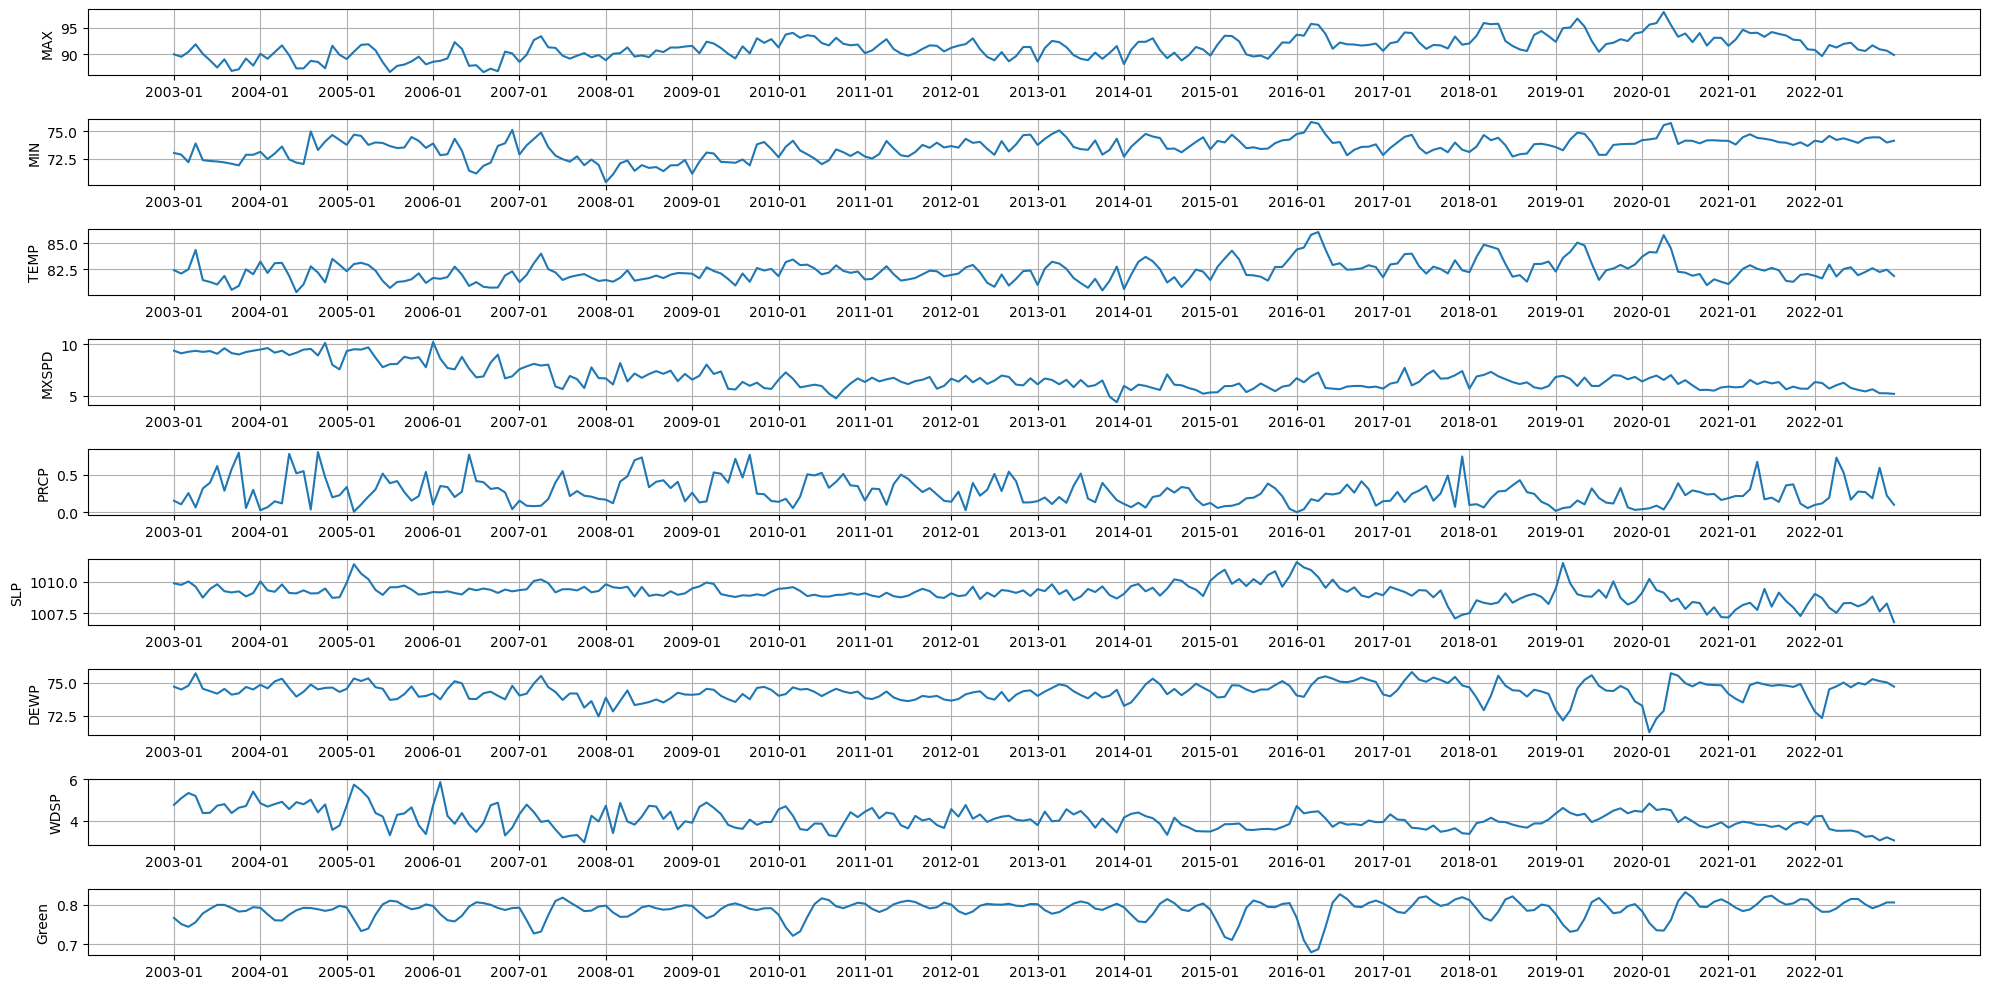

(240,)
(8, 240)


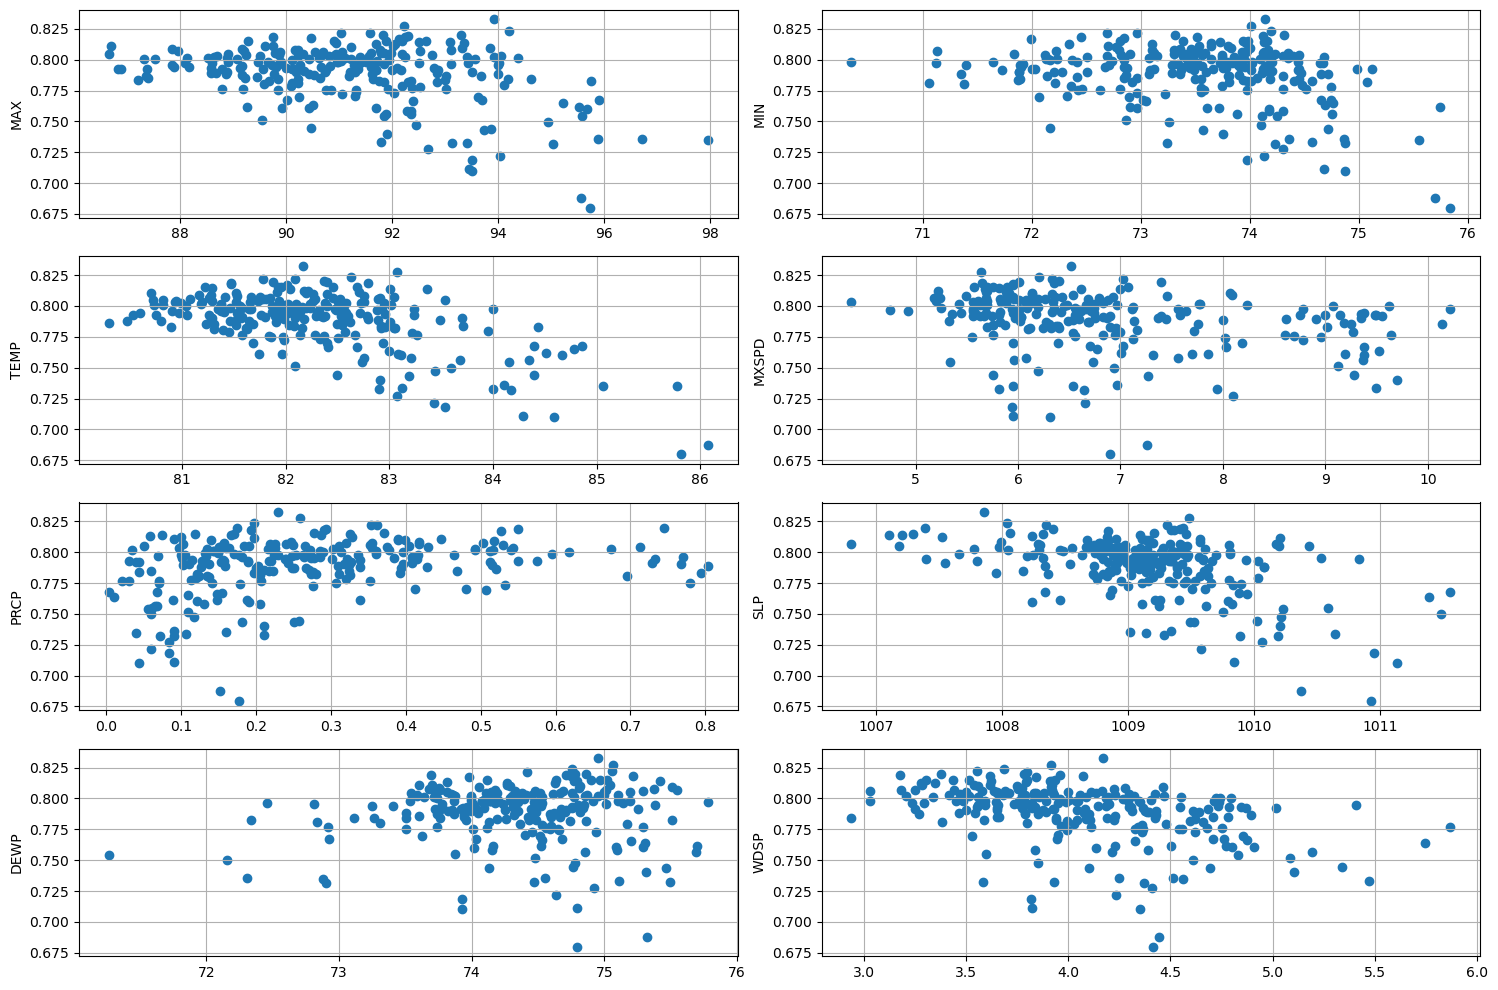

In [61]:
#Plotting the scatter of feature vs food prioce for triend
# unrolled_data = wm.year_data.reshape(-1, wm.year_data.shape[2]).T
feature_names = ["MAX", "MIN", "TEMP", "MXSPD", "PRCP", "SLP", "DEWP", "WDSP"]
# weather = pd.read_csv('ilocos-sur-weather.csv')
# weather = weather[["DATE"] + feature_names]

# wdata = weather[feature_names].to_numpy()
# wdata -= wm.seasonal
# wdata = wdata.reshape(-1, wdata.shape[2]).T

# wdata = pd.DataFrame(wdata, columns=feature_names)
# weather = weather[["DATE"] + feature_names]


# weather = weather.set_index("DATE")
# weather = weather.resample('ME').max()

weather = pd.DataFrame(wm.data[feature_names], columns=feature_names)
# weather = pd.DataFrame(wm.residuals, columns=feature_names)
weather["DATE"] = wm.data["DATE"]
weather = weather[(weather["DATE"].dt.year >= 2003) & (weather["DATE"].dt.year <= 2022)]
weather = weather.set_index("DATE")
weather = weather.resample('ME').mean()

green = pd.read_csv('ilocos-sur-green.csv')
green["#date"] = pd.to_datetime(green["#date"])
green = green[(green["#date"].dt.year >= 2003) & (green["#date"].dt.year <= 2022)]
green = green.set_index("#date")
green["residuals"] = green["#indicator+vim+num"] #- green["#indicator+vim_avg+num"]
green = green["residuals"].resample('ME').mean()
print(green.shape)

print("green", green.shape)

print(green.head(), green.tail())
print(weather.head(), weather.tail())

y = green.values
weather = weather.to_numpy().T
print(weather.shape)
print(wm.seasonal.shape)

plt.figure(figsize=(20, 10))


for i in range(len(weather)):
    plt.subplot(len(weather)+1, 1, i+1)
    plt.plot(weather[i])
    plt.xticks(ticks=np.arange(0, len(green), 12), labels=green.index[::12].strftime('%Y-%m'))
 
    plt.ylabel(feature_names[i])
    plt.grid()


plt.subplot(len(weather)+1, 1, len(weather)+1)
plt.plot(y)
plt.xticks(ticks=np.arange(0, len(green), 12), labels=green.index[::12].strftime('%Y-%m'))
plt.ylabel("Green")
plt.grid()
plt.tight_layout()

plt.show()

print(y.shape)
print(weather.shape)
plt.figure(figsize=(15, 10))
for i in range(len(weather)):
    plt.subplot(4, 2, i+1)
    plt.scatter(weather[i], y)
    plt.ylabel(feature_names[i])
    plt.grid()

plt.tight_layout()
plt.show()




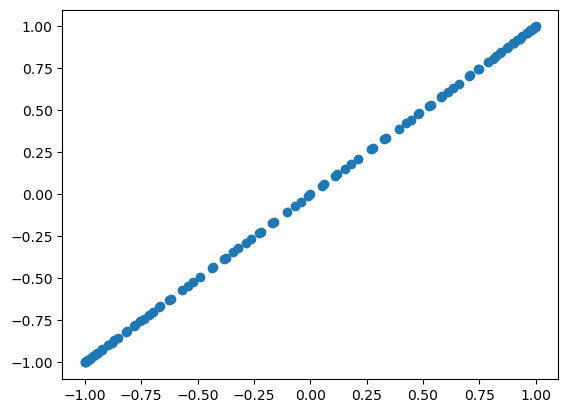

In [52]:
t = np.linspace(0, 50, 100)

x = np.sin(t)
y = np.sin(t)

plt.scatter(x, y)
plt.show()